## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [7]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
"""Code Here
建立你的神經網路
"""
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0825 20:21:47.349578 18396 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0825 20:21:47.352571 18396 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0825 20:21:47.485519 18396 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 20:21:47.486215 18396 deprecation_wrapper.py:119] From C:\Users\sam0522\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 20:21:47.49319

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0825 20:21:47.952963 18396 deprecation.py:323] From C:\Users\sam0522\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 232us/step - loss: 198.0953 - acc: 0.2277 - val_loss: 36.0508 - val_acc: 0.2605
Epoch 2/10
50000/50000 [==============================] - 10s 202us/step - loss: 15.9526 - acc: 0.1095 - val_loss: 5.1319 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 10s 198us/step - loss: 3.2094 - acc: 0.0996 - val_loss: 2.4716 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 10s 202us/step - loss: 2.4632 - acc: 0.0970 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 11s 214us/step - loss: 2.4624 - acc: 0.0996 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 11s 215us/step - loss: 2.4624 - acc: 0.0973 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 11s 210us/step - loss: 2.4624 - acc: 0.0970 - val_loss

50000/50000 [==============================] - 12s 233us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 11s 219us/step - loss: 2.4626 - acc: 0.0968 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 11s 211us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 8/10
50000/50000 [==============================] - 10s 209us/step - loss: 2.4626 - acc: 0.0976 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 9/10
50000/50000 [==============================] - 11s 219us/step - loss: 2.4626 - acc: 0.0959 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 10/10
50000/50000 [==============================] - 11s 211us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4626 - val_acc: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

50000/50000 [==============================] - 10s 201us/step - loss: 4.9825 - acc: 0.4783 - val_loss: 4.9795 - val_acc: 0.4617
Experiment with L1 = 0.000100, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 228us/step - loss: 15.0830 - acc: 0.2669 - val_loss: 13.9456 - val_acc: 0.3476
Epoch 2/10
50000/50000 [==============================] - 11s 214us/step - loss: 13.0109 - acc: 0.3601 - val_loss: 12.1215 - val_acc: 0.3746
Epoch 3/10
50000/50000 [==============================] - 11s 217us/step - loss: 11.3366 - acc: 0.3851 - val_loss: 10.5881 - val_acc: 0.3861
Epoch 4/10
50000/50000 [==============================] - 11s 220us/step - loss: 9.9252 - acc: 0.3975 - val_loss: 9.2860 - val_acc: 0.4035
Epoch 5/10
50000/50000 [==============================] - 11s 218us/step - loss: 8.7268 - acc: 0.4065 - val_loss: 8.1791 - val_acc: 0.4168
Epoch 6/10
50000/50000 [==============================] - 11s 223us/step - loss: 7.7037 - acc: 0.4175 - val_loss: 7.2419 - val_acc: 0.4191
Epoch 7/10
50000/50000 [==============================] - 11s 219us/step - loss: 6.8337 - acc: 0.4216 - val_lo

Epoch 6/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.5821 - acc: 0.4466 - val_loss: 1.5902 - val_acc: 0.4377
Epoch 7/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.5487 - acc: 0.4581 - val_loss: 1.5437 - val_acc: 0.4570
Epoch 8/10
50000/50000 [==============================] - 10s 195us/step - loss: 1.5162 - acc: 0.4693 - val_loss: 1.5210 - val_acc: 0.4617- loss: 1.5
Epoch 9/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.4892 - acc: 0.4779 - val_loss: 1.5100 - val_acc: 0.4703
Epoch 10/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.4635 - acc: 0.4866 - val_loss: 1.4834 - val_acc: 0.4714
Experiment with L1 = 0.000000, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
__________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 226us/step - loss: 2.0165 - acc: 0.2859 - val_loss: 1.8440 - val_acc: 0.3538
Epoch 2/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.7892 - acc: 0.3753 - val_loss: 1.7357 - val_acc: 0.3926
Epoch 3/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.7081 - acc: 0.4033 - val_loss: 1.6785 - val_acc: 0.4123
Epoch 4/10
50000/50000 [==============================] - 11s 222us/step - loss: 1.6519 - acc: 0.4222 - val_loss: 1.6384 - val_acc: 0.4232
Epoch 5/10
50000/50000 [==============================] - 11s 222us/step - loss: 1.6045 - acc: 0.4376 - val_loss: 1.5892 - val_acc: 0.4426
Epoch 6/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.5648 - acc: 0.4534 - val_loss: 1.5618 - val_acc: 0.4516
Epoch 7/10
50000/50000 [==============================] - 11s 210us/step - loss: 1.5310 - acc: 0.4655 - val_loss: 1.

Epoch 6/10
50000/50000 [==============================] - 9s 188us/step - loss: 7.7051 - acc: 0.4156 - val_loss: 7.2453 - val_acc: 0.4151
Epoch 7/10
50000/50000 [==============================] - 9s 186us/step - loss: 6.8324 - acc: 0.4236 - val_loss: 6.4412 - val_acc: 0.4294
Epoch 8/10
50000/50000 [==============================] - 10s 198us/step - loss: 6.0890 - acc: 0.4300 - val_loss: 5.7536 - val_acc: 0.4296
Epoch 9/10
50000/50000 [==============================] - 10s 195us/step - loss: 5.4527 - acc: 0.4360 - val_loss: 5.1663 - val_acc: 0.4357
Epoch 10/10
50000/50000 [==============================] - 10s 190us/step - loss: 4.9099 - acc: 0.4406 - val_loss: 4.6868 - val_acc: 0.4243
Experiment with L1 = 0.000000, L2 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_______________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 170us/step - loss: 2.0285 - acc: 0.2721 - val_loss: 1.8654 - val_acc: 0.3419
Epoch 2/10
50000/50000 [==============================] - 8s 157us/step - loss: 1.8052 - acc: 0.3670 - val_loss: 1.7553 - val_acc: 0.3818
Epoch 3/10
50000/50000 [==============================] - 8s 168us/step - loss: 1.7194 - acc: 0.3958 - val_loss: 1.6875 - val_acc: 0.4083
Epoch 4/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.6635 - acc: 0.4177 - val_loss: 1.6406 - val_acc: 0.4212
Epoch 5/10
50000/50000 [==============================] - 8s 161us/step - loss: 1.6188 - acc: 0.4322 - val_loss: 1.5963 - val_acc: 0.4395
Epoch 6/10
50000/50000 [==============================] - 8s 165us/step - loss: 1.5789 - acc: 0.4466 - val_loss: 1.5751 - val_acc: 0.4390
Epoch 7/10
50000/50000 [==============================] - 7s 150us/step - loss: 1.5471 - acc: 0.4569 - val_loss: 1.5508 - 

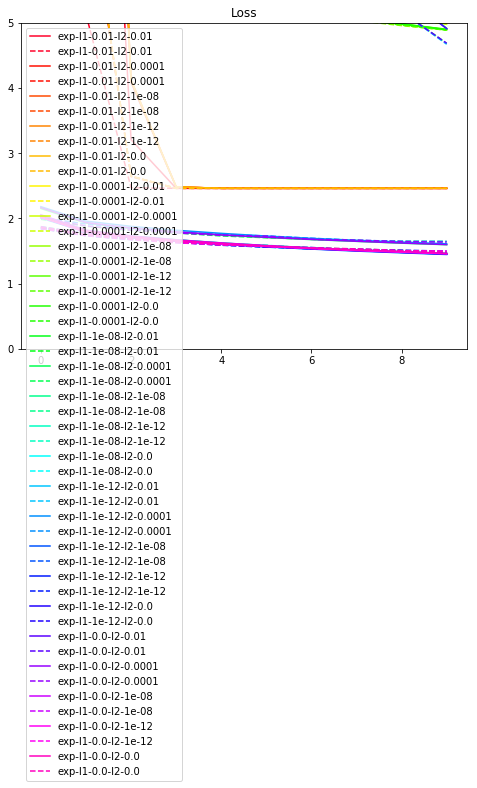

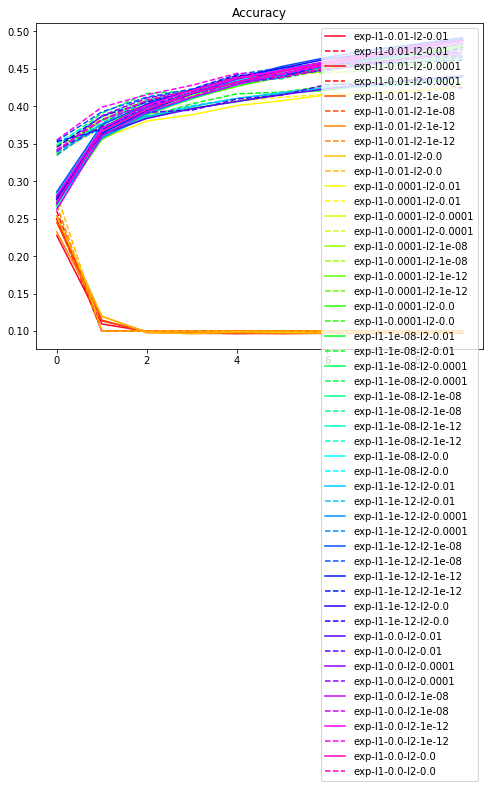

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()